In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout,Bidirectional
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import History 

from wordcloud import WordCloud, STOPWORDS


#for visualization
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [2]:
%%time
reviews_data= pd.read_csv("/content/sample_data/fake reviews dataset.csv")


CPU times: user 148 ms, sys: 73.9 ms, total: 222 ms
Wall time: 227 ms


In [3]:
reviews_data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
reviews_data.shape

(40432, 4)

In [5]:
reviews_data.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
reviews_data.label.value_counts()

CG    20216
OR    20216
Name: label, dtype: int64

In [7]:
reviews_data.isna().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [8]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [9]:
reviews_data.rating.value_counts()

5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: rating, dtype: int64

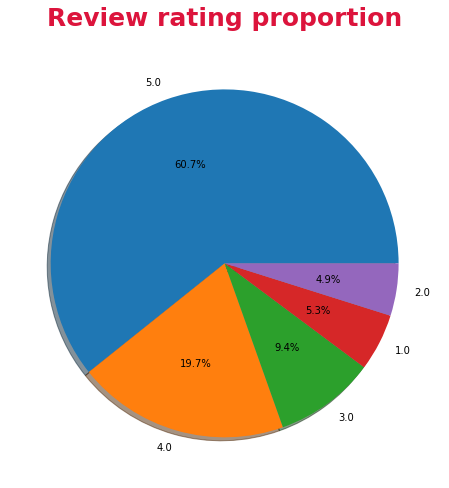

In [10]:
plt.figure(figsize=(15,8))
labels = reviews_data['rating'].value_counts().keys()
values = reviews_data['rating'].value_counts().values
plt.pie(values,labels=labels,shadow=True,autopct='%1.1f%%')
plt.title('Review rating proportion',fontweight='bold',fontsize=25,pad=20,color='crimson')
plt.show()

In [11]:
reviews_data.label = reviews_data.label.map(dict(CG=0, OR=1))

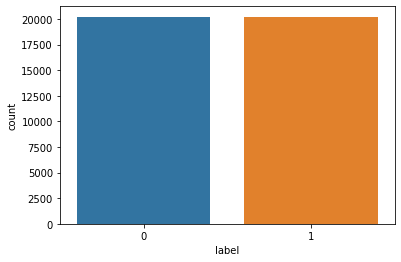

In [12]:
import seaborn as sns
fig = sns.countplot(x="label",data=reviews_data)
fig

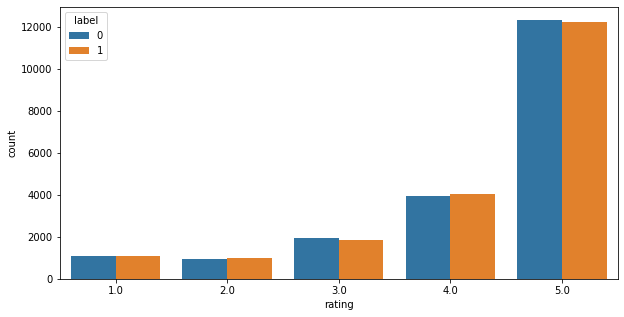

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x= "rating", hue = "label", data=reviews_data)

#Text Preprocessing

In [14]:
%%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions and convert to lowercase
    txt = txt.lower()
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]

    lemmatizer = nltk.stem.WordNetLemmatizer()
    def lemmatize_text(txt):
        return [lemmatizer.lemmatize(w) for w in words]

    cleaned_text = ' '.join(words)
    return cleaned_text
    
reviews_data['text_'] = reviews_data['text_'].apply(lambda txt: clean_text(txt))


CPU times: user 24.5 s, sys: 785 ms, total: 25.2 s
Wall time: 25.3 s


In [15]:
reviews_data.text_.head(1)

0    love well made sturdy comfortable love itvery ...
Name: text_, dtype: object

In [16]:
type(reviews_data.text_)

pandas.core.series.Series

In [17]:
reviews_data['text_'] = reviews_data['text_'].astype(str)

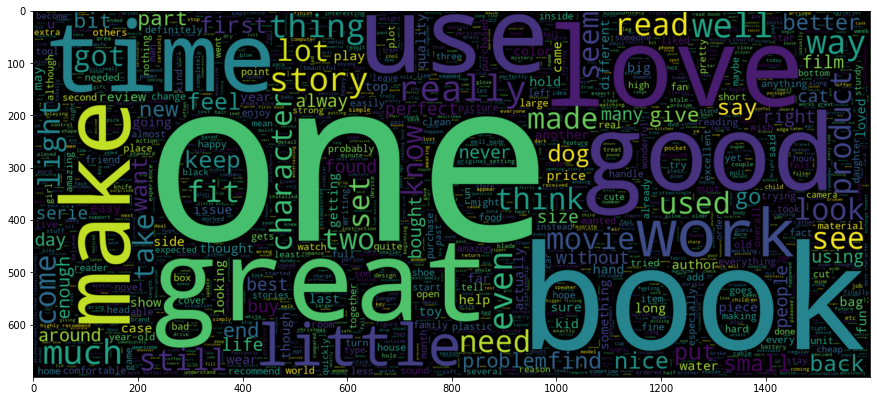

In [18]:
#Real words highlight
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(reviews_data[reviews_data.label==1].text_))
plt.imshow(wc, interpolation="bilinear")

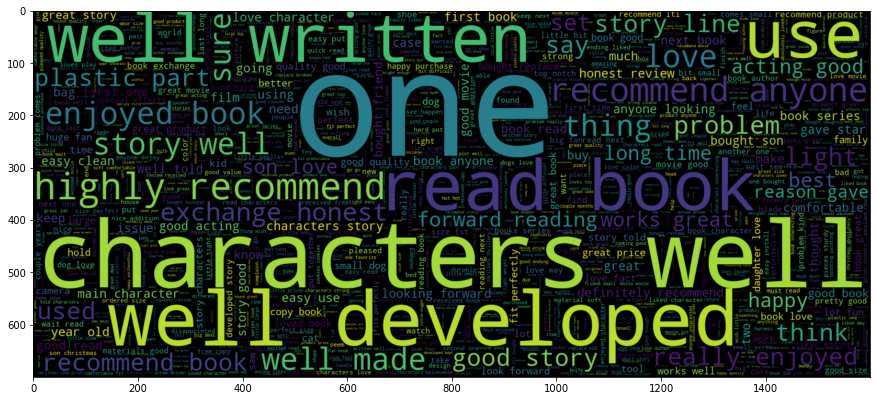

In [19]:
#Fake words highlight
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(reviews_data[reviews_data.label==0].text_))
plt.imshow(wc, interpolation="bilinear")

In [20]:
X= [d.split() for d in reviews_data['text_'].to_list()]
print(X[0])

['love', 'well', 'made', 'sturdy', 'comfortable', 'love', 'itvery', 'pretty']


In [21]:
print(len(X))

40432


In [22]:
DIM=100
w2v_model = gensim.models.Word2Vec(sentences = X, size = DIM, window =4,min_count=1)

In [23]:
len(w2v_model.wv.vocab)

48177

In [24]:
w2v_model['recommend']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.94409263, -2.2435334 , -0.83782595, -1.7853155 ,  3.421669  ,
       -0.02830799, -1.0208348 , -2.2588592 ,  0.16240402, -2.020514  ,
       -1.2670081 ,  0.4393603 , -0.38757816,  1.4769443 , -1.2632567 ,
        1.5543505 ,  1.2811842 ,  1.797962  ,  0.8056965 , -0.917469  ,
       -0.05928653, -1.1503613 ,  0.2805878 , -1.3951883 ,  0.56356615,
       -1.0968035 , -0.07473684, -2.619564  , -2.5676246 ,  1.5350245 ,
       -1.0733614 ,  2.7650745 , -1.0353765 , -0.6257014 ,  2.4529002 ,
       -1.8375633 , -1.4266475 ,  1.6633477 , -1.6249322 , -0.24563953,
        0.41211367,  2.5526137 ,  0.89021164, -1.9929891 ,  0.26140568,
       -0.37117216, -1.1031588 ,  4.290114  , -0.08724394,  2.3733544 ,
        0.87189794, -2.145255  ,  1.3801899 , -1.462824  , -0.7781026 ,
        0.30637008,  0.685702  ,  0.96788216,  0.64808595,  0.6301396 ,
       -1.2114671 ,  3.1436214 ,  3.9330914 , -3.1927147 , -0.3981869 ,
        1.2659292 ,  0.7136223 , -0.45914888, -2.0893888 ,  0.56

In [25]:
w2v_model['well']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.34186417,  0.00758959,  0.8443086 , -0.8663829 ,  0.52505517,
        0.94314504,  1.0865595 , -1.4079441 , -3.313089  , -0.6668592 ,
        0.24410945, -0.9291286 ,  0.11172088, -0.674333  , -1.6453091 ,
        1.7267793 , -0.55293924,  1.1694062 ,  0.39642233, -0.46398455,
       -1.5959232 , -0.54476684, -0.40148756, -1.3607438 ,  0.1674885 ,
       -1.1035709 , -1.4580891 , -0.19830658, -0.0817371 , -0.14606419,
       -2.4739661 ,  1.935322  , -0.8102244 ,  1.1864399 , -0.07989155,
        2.3581104 , -1.325584  , -0.45717806, -2.8739421 , -0.17350425,
        0.7228677 ,  1.1357214 ,  1.5411433 , -1.5926542 ,  0.44423264,
        0.27933845,  1.1434466 ,  1.1183498 ,  0.5276343 ,  0.5996679 ,
        1.8312662 , -0.1980265 ,  0.95519775,  0.4665372 , -1.3259705 ,
       -1.1952578 , -0.1867969 , -0.11342087,  0.6190812 ,  1.1147217 ,
       -0.6576663 ,  1.3997562 ,  0.49127138,  0.44724026, -0.24648191,
        0.09494364,  1.0002891 , -2.1681426 , -0.63719857, -1.03

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)
X=tokenizer.texts_to_sequences(X)
X

[[6, 7, 31, 113, 48, 6, 1297, 72],
 [6, 1, 1948, 339, 548, 100, 86],
 [654, 1740, 73, 6, 76, 95, 654],
 [951, 572, 16, 1, 26, 42],
 [20, 65, 3, 28, 65, 34, 180],
 [154, 105, 3748],
 [46, 616, 75, 118, 11, 450],
 [265, 37, 7, 76, 1, 6, 9469, 1752, 287],
 [1, 90, 2270, 21, 10, 75, 9, 25],
 [98, 24, 5241, 7, 31, 18, 527],
 [682, 877, 4, 84, 15],
 [878, 4, 175, 499, 550, 915, 4],
 [460, 91, 12849, 1, 26],
 [869, 28, 5, 492, 314, 1684],
 [159, 268, 1102, 11358, 84, 273, 78, 40],
 [260, 1158, 120, 42, 822, 190, 180],
 [6, 46, 25, 555, 14869, 3, 28],
 [76, 224, 20, 84, 15, 1346, 4],
 [350, 5, 492, 6, 76, 95, 654],
 [127, 5, 107, 13, 238, 6, 1599],
 [1, 11, 3115, 14870, 180],
 [682, 21, 16, 6, 295, 18, 1894],
 [350, 2082, 6, 76, 95, 654],
 [558, 154, 6, 76, 95, 654],
 [757, 189, 287, 1552, 84, 15, 879],
 [21, 16, 162, 21, 36, 56, 5089, 22, 329],
 [7345, 131, 193, 127],
 [20, 26, 853, 580, 234, 63, 314, 203, 271],
 [3, 17, 163, 65, 76, 9, 29, 4, 79],
 [303, 8804, 1079, 208, 84, 273, 78, 40],
 [

In [27]:
tokenizer.word_index

{'great': 1,
 'book': 2,
 'good': 3,
 'one': 4,
 'would': 5,
 'love': 6,
 'well': 7,
 'story': 8,
 'like': 9,
 'read': 10,
 'little': 11,
 'get': 12,
 'recommend': 13,
 'characters': 14,
 'really': 15,
 'use': 16,
 'bought': 17,
 'also': 18,
 'movie': 19,
 'nice': 20,
 'easy': 21,
 'small': 22,
 'time': 23,
 'loves': 24,
 'size': 25,
 'product': 26,
 'bit': 27,
 'quality': 28,
 'first': 29,
 'lot': 30,
 'made': 31,
 'series': 32,
 'used': 33,
 'two': 34,
 'much': 35,
 'way': 36,
 'fit': 37,
 'loved': 38,
 'works': 39,
 'put': 40,
 'work': 41,
 'price': 42,
 'still': 43,
 'could': 44,
 'light': 45,
 'perfect': 46,
 'dog': 47,
 'comfortable': 48,
 'see': 49,
 'long': 50,
 'enjoyed': 51,
 'think': 52,
 'old': 53,
 'happy': 54,
 'keep': 55,
 'make': 56,
 'anyone': 57,
 'author': 58,
 'looking': 59,
 'reading': 60,
 'got': 61,
 'best': 62,
 'plastic': 63,
 'buy': 64,
 'set': 65,
 'better': 66,
 'next': 67,
 'go': 68,
 'liked': 69,
 'want': 70,
 'even': 71,
 'pretty': 72,
 'back': 73,
 'book

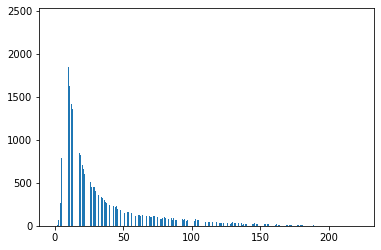

In [28]:
plt.hist([len(x) for x in X],bins=500)
plt.show()

In [29]:
n=np.array([len(x) for x in X])
len(n[n<=200]) #There around 40k reviews which has words within 150

40428

In [30]:
#get size of vocabulary
vocabulary=set()
for text in X:
   for word in text:
     if word  not in vocabulary:
       vocabulary.add(word)

vocab_length=len(vocabulary)
 #get max length of sequence
max_seq_length=0
for text in X:
   if len(text)>max_seq_length:
     max_seq_length=len(text)    
#results
print("vocab length:",vocab_length)
print("max sequence length:",max_seq_length)  

vocab length: 48177
max sequence length: 222


In [31]:
max_len=150
X=pad_sequences(X,maxlen=max_len)
len(X[1]) #The sentences are trimmed to 1000 for each ofthe 44k news articles now

150

In [32]:
tokenizer.num_words

In [33]:
vocab_size=len(tokenizer.word_index)+1   #Adding an extra zero vector to capture unknown words to avoid the error it throws 
#vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)
vocab=tokenizer.word_index
vocab

Vocabulary Size: 48178


{'great': 1,
 'book': 2,
 'good': 3,
 'one': 4,
 'would': 5,
 'love': 6,
 'well': 7,
 'story': 8,
 'like': 9,
 'read': 10,
 'little': 11,
 'get': 12,
 'recommend': 13,
 'characters': 14,
 'really': 15,
 'use': 16,
 'bought': 17,
 'also': 18,
 'movie': 19,
 'nice': 20,
 'easy': 21,
 'small': 22,
 'time': 23,
 'loves': 24,
 'size': 25,
 'product': 26,
 'bit': 27,
 'quality': 28,
 'first': 29,
 'lot': 30,
 'made': 31,
 'series': 32,
 'used': 33,
 'two': 34,
 'much': 35,
 'way': 36,
 'fit': 37,
 'loved': 38,
 'works': 39,
 'put': 40,
 'work': 41,
 'price': 42,
 'still': 43,
 'could': 44,
 'light': 45,
 'perfect': 46,
 'dog': 47,
 'comfortable': 48,
 'see': 49,
 'long': 50,
 'enjoyed': 51,
 'think': 52,
 'old': 53,
 'happy': 54,
 'keep': 55,
 'make': 56,
 'anyone': 57,
 'author': 58,
 'looking': 59,
 'reading': 60,
 'got': 61,
 'best': 62,
 'plastic': 63,
 'buy': 64,
 'set': 65,
 'better': 66,
 'next': 67,
 'go': 68,
 'liked': 69,
 'want': 70,
 'even': 71,
 'pretty': 72,
 'back': 73,
 'book

In [34]:
def get_weight_matrix(model): #Weight matrix is created to map the embedding vectors and its words
  weight_matrix=np.zeros((vocab_size,DIM))
  for word,i in vocab.items():
    weight_matrix[i]=model.wv[word]
  return weight_matrix

In [35]:
embedding_vectors=get_weight_matrix(w2v_model)
embedding_vectors.shape

(48178, 100)

In [36]:
##Train and test data creation
X_train, X_test, Y_train, Y_test = train_test_split(X, reviews_data['label'],test_size=0.2,stratify = reviews_data['label'],random_state=1)
# find the length of the largest sentence in training data
#max_len = xtrain.apply(lambda x: len(xtrain)).max()
#print(f'Max number of words in a text in training data: {max_len}')
X_train.shape


(32345, 150)

In [37]:
X_test.shape

(8087, 150)

#Modelling using Passive Aggressive Classifier for Word2vec


In [38]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
linear_clf = PassiveAggressiveClassifier(random_state=42)
linear_clf.fit(X_train, Y_train.ravel())
pred = linear_clf.predict(X_test)
score = accuracy_score(Y_test,pred)
print(score)
print(confusion_matrix(Y_test,pred))
print(classification_report(Y_test, pred))

0.5423519228391245
[[2381 1662]
 [2039 2005]]
              precision    recall  f1-score   support

           0       0.54      0.59      0.56      4043
           1       0.55      0.50      0.52      4044

    accuracy                           0.54      8087
   macro avg       0.54      0.54      0.54      8087
weighted avg       0.54      0.54      0.54      8087



#Modelling using SVM classifier for Word2vec


In [39]:
from sklearn.svm import SVC
clf = SVC()
# train the model
clf.fit(X_train,Y_train)
# use the model to predict the testing instances
y_pred = clf.predict(np.array(X_test))
# generate the classification report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      4043
           1       0.82      0.68      0.74      4044

    accuracy                           0.76      8087
   macro avg       0.77      0.76      0.76      8087
weighted avg       0.77      0.76      0.76      8087



#Modelling using Bi LSTM for Word2vec

In [40]:
from tensorflow.keras.optimizers import Adam
def set_model(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=max_len, 
                        trainable=False))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt =Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model

In [73]:
%%time
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = set_model(embedding_vectors = embedding_vectors)
model.summary()
from keras.callbacks import Callback, EarlyStopping,ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, mode='auto')
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
batch_size = 64
epochs  = 8
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test), batch_size = batch_size, epochs = epochs,callbacks=[early_stop,mc])
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          4817800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,902,409
Trainable params: 84,609
Non-trainable params: 4,817,800
_________________________________________________________________
Epoch 1/8
506/506 [==============================] - ETA: 0s - loss: 0.3388 - acc: 0.8459
Epoch 1: val_ac

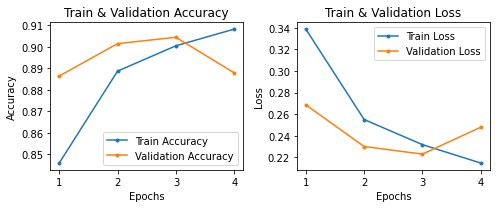

In [74]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
plot_loss_epochs(history)

253/253 [==============================] - 12s 43ms/step
accuracy: 88.78446890070484
              precision    recall  f1-score   support

        Fake       0.84      0.96      0.90      4044
        Real       0.95      0.81      0.88      4043

    accuracy                           0.89      8087
   macro avg       0.90      0.89      0.89      8087
weighted avg       0.90      0.89      0.89      8087



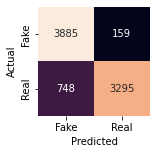

In [75]:
import seaborn as sns
#text_test_tok = tokenizer.texts_to_sequences(xtest)
pred = (model.predict(X_test) > 0.5).astype("int32")
print("accuracy:",accuracy_score(Y_test,pred)*100)
print(classification_report(Y_test, pred, target_names = ['Fake','Real'])) 
cm = pd.DataFrame(confusion_matrix(Y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()


In [44]:
#x=['NEW YORK/WASHINGTON (Reuters) - The new U.S. tax code targets high-tax states and may be unconstitutional, New York Governor Andrew Cuomo said on Thursday,saying that the bill may violate New York residentsâ€™ rights to due process and equal protection.  The sweeping Republican tax bill signed into law by U.S. President Donald Trump on Friday introduces a cap, of $10,000,  on deductions of state and local income and property taxes, known as SALT. The tax overhaul was the partyâ€™s first major legislative victory since Trump took office in January.  The SALT provision will hit many taxpayers in states with high incomes, high property values and high taxes, like New York, New Jersey and California. Those states are generally Democratic leaning.  â€œIâ€™m not even sure what they did is legally constitutional and thatâ€™s something weâ€™re looking at now,â€ Cuomo said in an interview with CNN. In an interview with CNBC, Cuomo suggested why the bill may be unconstitutional.  â€œPolitics does not trump the law,â€ Cuomo said on CNBC. â€œYou have the constitution, you have the law, you have due process, you have equal protection. You canâ€™t use politics just because the majority controls to override the law.â€ The Fifth Amendment of the Constitution, better known for its protection against self-incrimination, also protects individuals from seizure of life, liberty or property without due process and has been interpreted by the Supreme Court as guaranteeing equal protection by the law.  Cuomo and California Governor Jerry Brown, both Democrats, have previously said they were exploring legal challenges to SALT deduction limits.  Law professors have said legal challenges would likely rest on arguing that the provision interferes with the protection of statesâ€™ rights under the U.S. Constitutionâ€™s 10th Amendment. Tax attorneys said Cuomoâ€™s legal argument against the tax bill could be that it discriminates and places an unjust tax burden on states that heavily voted for Democrats in the past - known as â€œblue states.â€ â€œThe de facto effect of this legislation is to discriminate against blue states and particularly from (Cuomoâ€™s) perspective the state of New York,â€ said Joseph Callahan, an attorney with the law firm Mackay, Caswell & Callahan in New York.  But some tax experts noted the U.S. Supreme Court has interpreted the 16th Amendment to give Congress broad latitude to tax as it sees fit. In a frequently cited 1934 decision, the Supreme Court called tax deductions a â€œlegislative graceâ€ rather than a vested right. â€œI donâ€™t understand how they think they have a valid lawsuit here,â€ David Gamage, a professor of tax law at Indiana Universityâ€™s Maurer School of Law, told Reuters last week, speaking generally about governors in blue states that could challenge the tax bill.  Cuomo also said on Thursday that New York is proposing a restructuring of its tax code. He provided no details.  A group of 13 law professors on Dec. 18 published a paper suggesting ways that high-tax states could minimize the effects of the SALT deduction cap.  Their suggestions included shifting more of the tax burden onto businesses in the form of higher employer-side payroll taxes, since the federal tax billâ€™s cap on SALT deductions only applies to individuals and not businesses. States also could raise taxes on pass-through entities, which the federal tax bill specifically benefits with a lower rate on a portion of their income. On Friday, Cuomo said he would allow state residents to make a partial or full pre-payment on their property tax bill before Jan. 1, allowing taxpapyers to deduct such payments for 2017 before the cap kicks in, prompting a wave of residents to pay early.  However, the U.S. Internal Revenue Service on Wednesday advised homeowners that the pre-payment of 2018 property taxes may not be deductible.']
x=['These towels are real nice, and I love the feel of them.  They have a nice feel']
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=max_len)

In [76]:
(model.predict(x) >0.5).astype(int)

1/1 [==============================] - 0s 28ms/step


array([[0]])

# GLOVE

In [77]:
# create tokenizer object
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_data['text_'].tolist())

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 48178


In [78]:
x_train = pad_sequences(tokenizer.texts_to_sequences(reviews_data['text_'].tolist()),
                        maxlen = max_len)
# x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.title),
#                        maxlen = max_sequence_length)

print("Training X Shape:",x_train.shape)

Training X Shape: (40432, 150)


In [79]:
print(x_train)

[[    0     0     0 ...     6  1297    72]
 [    0     0     0 ...   548   100    86]
 [    0     0     0 ...    76    95   654]
 ...
 [  326   237 16595 ...  1378 14999  2926]
 [    0     0     0 ...    48    76     1]
 [   76   671  1176 ...   111   809   126]]


In [80]:
word_index

{'great': 1,
 'book': 2,
 'good': 3,
 'one': 4,
 'would': 5,
 'love': 6,
 'well': 7,
 'story': 8,
 'like': 9,
 'read': 10,
 'little': 11,
 'get': 12,
 'recommend': 13,
 'characters': 14,
 'really': 15,
 'use': 16,
 'bought': 17,
 'also': 18,
 'movie': 19,
 'nice': 20,
 'easy': 21,
 'small': 22,
 'time': 23,
 'loves': 24,
 'size': 25,
 'product': 26,
 'bit': 27,
 'quality': 28,
 'first': 29,
 'lot': 30,
 'made': 31,
 'series': 32,
 'used': 33,
 'two': 34,
 'much': 35,
 'way': 36,
 'fit': 37,
 'loved': 38,
 'works': 39,
 'put': 40,
 'work': 41,
 'price': 42,
 'still': 43,
 'could': 44,
 'light': 45,
 'perfect': 46,
 'dog': 47,
 'comfortable': 48,
 'see': 49,
 'long': 50,
 'enjoyed': 51,
 'think': 52,
 'old': 53,
 'happy': 54,
 'keep': 55,
 'make': 56,
 'anyone': 57,
 'author': 58,
 'looking': 59,
 'reading': 60,
 'got': 61,
 'best': 62,
 'plastic': 63,
 'buy': 64,
 'set': 65,
 'better': 66,
 'next': 67,
 'go': 68,
 'liked': 69,
 'want': 70,
 'even': 71,
 'pretty': 72,
 'back': 73,
 'book

In [81]:
reviews_data['label'].unique().tolist()

[0, 1]

In [82]:
y_train = reviews_data['label']
y_train = y_train.values.reshape(-1,1)
# y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)

y_train shape: (40432, 1)


In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size = 0.2, stratify=y_train,random_state = 42)
X_train.shape

(32345, 150)

In [84]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-11-22 04:14:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-22 04:14:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-22 04:14:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [85]:

!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [86]:
glv_emb = open('glove.6B.100d.txt', encoding='utf8')

In [87]:
embeddings_index = {}

for line in glv_emb:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    embeddings_index[word] = vectors
        
glv_emb.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#verifying how glove behaves if out of vocabulary is given
embeddings_index.get('recommend').shape

In [ ]:
tokenizer.word_index.items()

In [90]:
#Finding out of vocabulary words
word_vector_matrix=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
      word_vector_matrix[index]=vector
    else:
      print(word)   

Streaming output truncated to the last 5000 lines.
poucha
hrefgetnakedlowcaloriedentalchewsticksfordogssmallouncestickspackdpbaylnurefcmcrarpdrvwtxtieutfget
smallounce
stickspacka
hrefnboneoralhyginetwistixtwestedstickdogtreatssmallozdpbwflonarefcmcrarpdrvwtxtieutfn
hygine
twistix
twested
ozanbspand
hrefbluebuffalominibluebonesnaturaldogdentalchewsdpbbzqbkrefcmcrarpdrvwtxtieutfblue
chewsa
bottlemy
bottlewe
hrefosteraturbospeedprofessionalanimalclipperdpblrnarefcmcrarpdrvwtxtieutfoster
clipperanbsphas
mynbspa
hrefandiseasyclipproanimalpiecedetachablebladeclipperkitpetgroomingmbgdpbutforefcmcrarpdrvwtxtieutfandis
easyclip
humanhome
highestend
hrefwahlprofessionalanimalstainlesssteelguidecombsdpbrbwlgrefcmcrarpdrvwtxtieutfwahl
knowmy
itemthis
clothcovered
downanyway
trackout
puppiesdogs
worsecat
digestionmy
idvideoblockravfnw
heightsize
tonbspa
anbspfor
clefthoofed
anbspinstead
worksworkedetc
ownerthis
elsethese
rainthe
wellbehavedmy
antichlorine
agaefix
againas
fountainit
strictmy
watche

In [91]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
linear_clf = PassiveAggressiveClassifier(random_state=42)
linear_clf.fit(X_train, Y_train.ravel())
pred = linear_clf.predict(X_test)
score = accuracy_score(Y_test,pred)
print(score)
print(confusion_matrix(Y_test,pred))
print(classification_report(Y_test, pred))

0.5161370100160751
[[1278 2766]
 [1147 2896]]
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      4044
           1       0.51      0.72      0.60      4043

    accuracy                           0.52      8087
   macro avg       0.52      0.52      0.50      8087
weighted avg       0.52      0.52      0.50      8087



In [92]:
from sklearn.svm import SVC
clf = SVC()
# train the model
clf.fit(X_train,Y_train.ravel())
# use the model to predict the testing instances
y_pred = clf.predict(np.array(X_test))
# generate the classification report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      4044
           1       0.80      0.68      0.74      4043

    accuracy                           0.76      8087
   macro avg       0.76      0.76      0.75      8087
weighted avg       0.76      0.76      0.75      8087



In [93]:
LR = 1e-3
EMBEDDING_DIM = 100
BATCH_SIZE = 64
EPOCHS = 8

In [94]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[word_vector_matrix],
                                          input_length=150,
                                          trainable=False)

##Modelling

##BILSTM WITH GLOVE

In [95]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 100)          4817800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,902,409
Trainable params: 84,609
Non-trainable params: 4,817,800
_________________________________________________________________
None


In [96]:
%%time
from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
batch_size = 64
epochs  = 8
history = lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test), batch_size = batch_size, epochs = epochs,callbacks=[early_stop,mc])
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/8
506/506 [==============================] - ETA: 0s - loss: 0.4738 - acc: 0.7583
Epoch 1: val_acc improved from -inf to 0.78719, saving model to best_model.h5
506/506 [==============================] - 142s 274ms/step - loss: 0.4738 - acc: 0.7583 - val_loss: 0.4289 - val_acc: 0.7872
Epoch 2/8
506/506 [==============================] - ETA: 0s - loss: 0.3627 - acc: 0.8294
Epoch 2: val_acc improved from 0.78719 to 0.84024, saving model to best_model.h5
506/506 [==============================] - 138s 272ms/step - loss: 0.3627 - acc: 0.8294 - val_loss: 0.3417 - val_acc: 0.8402
Epoch 3/8
506/506 [==============================] - ETA: 0s - loss: 0.3060 - acc: 0.8618
Epoch 3: val_acc improved from 0.84024 to 0.86336, saving model to best_model.h5
506/506 [==============================] - 137s 271ms/step - loss: 0.3060 - acc: 0.8618 - val_loss: 0.2984 - val_acc: 0.8634
Epoch 4/8
506/506 [==============================] - ETA: 0s - loss: 0.2759 - acc: 0.8771
Epoch 4: val_acc improved

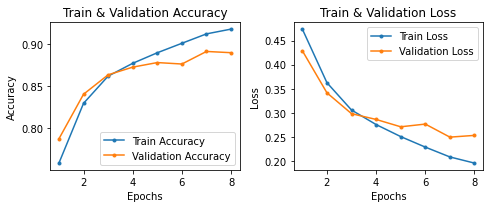

In [97]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
plot_loss_epochs(history)


253/253 [==============================] - 11s 42ms/step
accuracy: 88.96995177445282
              precision    recall  f1-score   support

        Fake       0.92      0.85      0.89      4044
    Not Fake       0.86      0.93      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



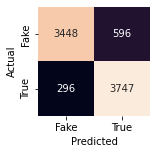

In [98]:
import seaborn as sns
#text_test_tok = tokenizer.texts_to_sequences(xtest)
pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
print("accuracy:",accuracy_score(Y_test,pred)*100)
print(classification_report(Y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(Y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()


##GRU with Glove Embeddings

In [99]:
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, EMBEDDING_DIM, trainable = False, weights=[word_vector_matrix]))
#gru_model.add(Dropout(0.2))
gru_model.add(Bidirectional(GRU(64)))
#gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         4817800   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              63744     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,881,673
Trainable params: 63,873
Non-trainable params: 4,817,800
_________________________________________________________________
None


In [100]:
%%time
from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, mode='auto')
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
batch_size = 64
epochs  = 8
history = gru_model.fit(X_train,Y_train,validation_data=(X_test,Y_test), batch_size = batch_size, epochs = epochs,callbacks=[early_stop,mc])
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/8
506/506 [==============================] - ETA: 0s - loss: 0.4847 - acc: 0.7493
Epoch 1: val_acc improved from -inf to 0.81959, saving model to best_model.h5
506/506 [==============================] - 108s 206ms/step - loss: 0.4847 - acc: 0.7493 - val_loss: 0.3885 - val_acc: 0.8196
Epoch 2/8
506/506 [==============================] - ETA: 0s - loss: 0.3519 - acc: 0.8374
Epoch 2: val_acc improved from 0.81959 to 0.85174, saving model to best_model.h5
506/506 [==============================] - 99s 196ms/step - loss: 0.3519 - acc: 0.8374 - val_loss: 0.3263 - val_acc: 0.8517
Epoch 3/8
506/506 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.8683
Epoch 3: val_acc improved from 0.85174 to 0.86386, saving model to best_model.h5
506/506 [==============================] - 99s 196ms/step - loss: 0.2954 - acc: 0.8683 - val_loss: 0.3087 - val_acc: 0.8639
Epoch 4/8
506/506 [==============================] - ETA: 0s - loss: 0.2575 - acc: 0.8860
Epoch 4: val_acc improved f

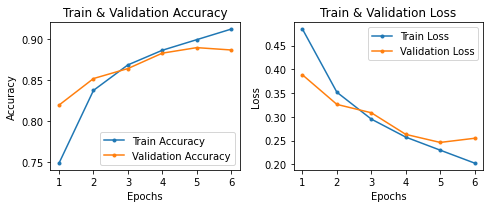

In [101]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
plot_loss_epochs(history)


253/253 [==============================] - 9s 34ms/step
accuracy: 88.63608260170645
              precision    recall  f1-score   support

        Fake       0.92      0.84      0.88      4044
    Not Fake       0.86      0.93      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



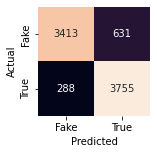

In [102]:
import seaborn as sns
#text_test_tok = tokenizer.texts_to_sequences(xtest)
pred = (gru_model.predict(X_test) >0.5).astype("int32")
print("accuracy:",accuracy_score(Y_test,pred)*100)
print(classification_report(Y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(Y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()
